# Übungsblatt 4 - Grundkonzepte der Datenanalyse und Visualisierung WS 2024/25

Ziel dieses Übungsteils ist es, Klassifikations- sowie Clusteringverfahren mit Hilfe der in der Vorlesung vorgestellten Bibliotheksfunktionen anzuwenden. 

Das Übungsblatt besteht aus folgenden Teilen:
* Klassifikation (Datensatz: Klassifikation von Sternen):
  * Erste Analyse der Daten/Baseline
  * k-nearest Neighbour Classifier
* Clustering (Datensatz: Stromverbrauch eines Haushalts):
  * k-means Clustering
  * Agglomeratives Clustering

Am Beginn steht natürlich wieder der Import der benötigten Bibliotheken.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# scikit-learn Importe fuer kNN
from sklearn.neighbors import KNeighborsClassifier 

# scikit-learn Importe fuer Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

# scikit-learn Importe fuers Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# scikit-learn Importe fuer die Evaluierung
from sklearn.metrics import silhouette_score

# Grafiken im Notebook anzeigen
%matplotlib inline      

# Klassifikation (Eigenschaften/Klassifikation von Sternen)

## Beschreibung des Datensatzes

Der Datensatz stammt aus [folgender Quelle](https://www.kaggle.com/datasets/deepu1109/star-dataset/data). Es handelt sich um eine Sammlung verschiedener Eigenschaften von Sternen, die aus verschiedenen Quellen zusammengetragen/berechnet wurden.

Wie üblich ist es für die Übung nicht notwendig, dass Sie die Daten selber verstehen. Für die Übung wird es nur relevant sein, dass der Datensatz verschiedene Arten von Merkmalen enthält. Eines dieser Merkmale beschreibt eine Klassifizierung, die wir aus den anderen Werten ablesen möchten. 

Falls Sie sich doch etwas mehr für die Daten interessieren, der Datensatz enthält die folgenden Merkmale:
1) Temperature: Die absolute Temperatur des Sterns (in °K)
2) Luminosity: Die relative Helligkeit des Sterns (relativ zur Helligkeit der Sonne)
3) Radius: Der relative Radius des Sterns (relativ zum Radius der Sonne)
4) Absolute magnitude: Die absolute Leuchtkraft des Sterns
5) Star type: Der Typ des Sterns (eine Klassifizierung)
6) Star color: Die Farbe des Sterns
7) Spectral Class: Die Spektralklasse des Sterns (eine Klassifizierung)

Das Merkmal __Star type__ kodiert den Typ des Sterns als:
+ 0: Brauner Zwerg
+ 1: Roter Zwerg
+ 2: Weißer Zwerg
+ 3: Stern der Hauptreihe
+ 4: Supergiant (Riesen)
+ 5: Hyergiant (Überriesen)


Typischerweise können diese Werte verwendet werden, um den Typ eines Sternes (__Star type__) zu beschreiben/bestimmen. Wir werden allerdings einen wenig anderen Weg gehen, und versuchen die Spektralklasse eines Sterns mit einem k-NN Verfahren zu klassifizieren.

In [2]:
df_stars = pd.read_csv('StarDataset.csv', sep=',')  # Datensatz laden
target_column = "Spectral Class"                    # Wir merken uns schon einmal, welches Merkmal unsere Klasse beschreibt

df_stars

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Blue,O
236,30839,834042.000000,1194.0000,-10.63,5,Blue,O
237,8829,537493.000000,1423.0000,-10.73,5,White,A
238,9235,404940.000000,1112.0000,-11.23,5,White,A


### Analyse der Daten

Nach dem Laden der Daten betrachten wir wie üblich ein paar grundlegende Eigenschaften des Datensatzes. Machen Sie sich etwas mit dem Datensatz vertraut, und behalten Sie vor allem im Hinterkopf, dass wir eine Klassifikation mittels k-NN durchführen möchten.

In [3]:
df_stars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
 6   Spectral Class          240 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 13.3+ KB


In [4]:
df_stars.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


In [5]:
df_stars["Star type"].value_counts()

Star type
0    40
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64

In [6]:
df_stars["Star color"].value_counts()

Star color
Red                   112
Blue                   56
Blue-white             26
Blue White             11
yellow-white            8
White                   7
white                   3
Yellowish White         3
Blue white              3
yellowish               2
Whitish                 2
Orange                  2
White-Yellow            1
Pale yellow orange      1
Yellowish               1
Orange-Red              1
Blue-White              1
Name: count, dtype: int64

Was fällt Ihnen bei der Analyse der Daten auf? 
Sind die Daten in ihrer aktuell vorliegenden Form für eine k-NN Klassifikation geeignet?
Welche Preprocessing Schritte würden Sie vornehmen?
(Erfordert keine Antwort, aber überlegen Sie sich die Antworten zu diesen Fragen. Tun Sie dies im Idealfall, bevor Sie weiterschauen. Überlegen Sie aber später, nachdem Sie die nächsten Schritte abgearbeitet haben, auch, ob Sie etwas anders/mehr gemacht hätten - vielleicht haben wir aus Zeitgründen ja etwas ausgelassen.)

### Erstes Aufbereiten der Daten (muss nach dem Laden der Daten immer ausgeführt werden!)
Im letzten Schritt der Analyse haben wir gesehen, dass die Beschreibung der Farben nicht einheitlich geschehen ist. Wir werden versuchen durch Einführen einheitlicher Bezeichnungen die Anzahl der unterschiedlichen Farben zu reduzieren. Dabei müssen wir zwei unterschiedliche Probleme beheben: 
Es gibt unterschiedliche Farbbezeichnungen, die ganz klar den selben Wert beschreiben (z.B. "White" und "white"). Es gibt aber auch Bezeichnungen, bei denen nicht unbedingt klar ist, ob sie die selbe oder tatsächlich unterschiedlche Farben beschreiben sollen (z.B. "White" und "Whitetisch"; aber auch "White-Yellow" und "yellow-white"). Um uns die weitere Übung etwas einfacher zu machen, fassen wir etwas großzügig zusammen.

In [7]:
# einheitliche Schreibweise bzgl. Bindestriche
df_stars["Star color"] = df_stars["Star color"].str.replace('-', ' ')
# einheitliche Schreibweise bzgl. Groß-Kleinschreibung
df_stars["Star color"] = df_stars["Star color"].str.lower()
# Wir machen keine Unterscheidung von "ish" zur Farbe
df_stars["Star color"] = df_stars["Star color"].str.replace('yellowish', 'yellow')   
df_stars["Star color"] = df_stars["Star color"].str.replace('whitish', 'white')
# Wir unterscheiden nicht zwischen Weißgelb und Gelbweiß
df_stars["Star color"] = df_stars["Star color"].str.replace('white yellow', 'yellow white')

df_stars["Star color"].value_counts()

Star color
red                   112
blue                   56
blue white             41
white                  12
yellow white           12
yellow                  3
orange                  2
pale yellow orange      1
orange red              1
Name: count, dtype: int64

Wir sehen nun, dass trotz dem großzügigen Zusammenfassen einige Farben nur sehr selten vorkommen. Wenn wir die Daten später in Trainings- und Testdaten unterteilen wollen, kann das ein Problem sein, da eine Farbe z.B. nur in den Test-, nicht jedoch in den Trainingsdaten aufscheinen kann. 

Um ein möglichst breit anwendbares Modell zu erhalten, müssten wir sicherstellen, dass von jeder Farbe mindestens ein Eintrag in den Trainingsdaten liegt (immerhin könnte die Farbe ja in zukünftigen, ungesehenen Daten auf denen das Modell angewendet werden soll auch auftreten). Wir machen uns die Arbeit aber wieder ein Stück einfacher, und entfernen alle Einträge mit Farben, die nicht mindestens 10 mal auftreten, aus dem Datensatz.

In [8]:
vcounts = df_stars["Star color"].value_counts()
df_stars = df_stars[df_stars["Star color"].isin(vcounts[vcounts >= 10].index)]
df_stars["Star color"].value_counts()

Star color
red             112
blue             56
blue white       41
white            12
yellow white     12
Name: count, dtype: int64

### Ermitteln einer simplen Baseline

Nachdem wir die Daten nun etwas gesäubert haben, können wir uns dem eigentlichen Klassifikationsproblem zuwenden. Um die Qualität unserer Modelle später besser einschätzen zu können, beginnen wir damit eine Baseline zu ermitteln, gegen welche wir die Ergebnisse unserer Klassifizierung vergleichen können. Wie in der Vorlesung besprochen ist eine Möglichkeit der Klassifizierung einfach immer die häufigste Klasse vorherzusagen. Wir möchten daher die Verteilung der Spektralklassen sowie die daraus resultierende Baseline bestimmen.

In [9]:
## Geben Sie die Verteilung der absoluten Werte der verschiedenen Spektralklassen aus 
## (egal ob visuell oder einfach nur durch die Ausgabe der absoluten Zahlen)
## 
## Berechnen Sie daraus eine Baseline für die Klassifikation - d.h. auf den vorhandenen 
## Daten den Anteil an Einträgen die wir korrekt klassifizieren würden, wenn wir
## immer die häufigste Spektralklasse annehmen würden.
## Speichern Sie den Wert für die Baseline in der Variable 
##   stars_baseline
## und die Bezeichnung der am häufigsten vorkommenden Spektralklasse in der Variable
##   spectral_class 

spectral_class = df_stars[target_column].value_counts().idxmax()
stars_baseline = df_stars[target_column].value_counts().max()/len(df_stars)

print(f'Baseline: Häufigste Spektralklasse: {spectral_class} mit Anteil: {stars_baseline}')

Baseline: Häufigste Spektralklasse: M mit Anteil: 0.4721030042918455


In [10]:
assert 0.4 < stars_baseline < 0.5, 'Baseline nicht im erwareteten Bereich'   # so viel sei verraten
assert spectral_class in 'MOBA'                                        # so viel sei verraten
assert len(spectral_class) == 1



### Trennung von Trainings- und Testdaten

Wir haben nun eine untere Schranke, welche uns hilft die Qualität unserer Modelle einzuschätzen. Um die Klassifizierungen im Folgenden aber überhaupt sinnvoll testen zu können, benötigen wir von den Trainingsdaten möglichst unabhängige Testdaten. Dazu unterteilen wir den Datensatz ```df_stars``` nun in Trainings- und Testdaten, von denen wir nur die Trainingsdaten zum Trainieren des k-NN Modells verwenden werden, und die Testdaten zum Evaluieren.

In [11]:
## Teilen Sie die Einträge in df_stars in Test- und Trainingsdaten auf. 
## Verwenden Sie dazu die in der Vorlesung vorgestellte Methode
##    train_test_split [1]
## Die Größe der Testdaten soll 30% der Gesamtdaten betragen, und die 
## Daten sollen vor dem Aufteilen gemischt werden (wir wissen nicht, 
## ob die Daten in 'df_stars' sortiert sind und gehen besser kein Risiko ein). 
## Verwenden Sie die Zahl 202412 um den random_state zu initialisieren, 
## um immer die selbe Aufteilung zu erreichen (hier in der Übung für die 
## Nachvollziehbarkeit, Testen und Bewerten wichtig; in "echten" Anwendungen 
## fraglich ob sinnvoll).
##
## Unterteilen Sie die Daten in insgesamt zwei DataFrames und zwei Series-Objekte:
##  - stars_training (DataFrame): Die Trainingsdaten ohne dem Klassenmerkmal "Spectral Class" 
##               (enthält alle Merkmale des Datensatzes die nicht das Klassenmerkmal sind)
##  - stars_test (DataFrame): Die Testdaten ohne dem Klassenmerkmal "Spectral Class" 
##               (enthält alle Merkmale des Datensatzes die nicht das Klassenmerkmal sind)
##  - stars_training_class (Series): Das Merkmal "Spectral Class" der Trainingsdaten
##  - stars_test_class (Series): Das Merkmal "Spectral Class" der Testdaten
##
## Achten Sie selbstverständlich darauf, dass die Reihenfolge der Einträge in 'stars_training'
## und 'stars_training_class' übereinstimmen; genauso für 'stars_test' und 'stars_test_class'.
## Bei (korrekter) Verwendung von 'train_test_split()' ist dies aber garantiert.
##
## [1] https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html

df_stars_train, df_stars_test = train_test_split(df_stars, test_size=0.3, random_state=202412, shuffle=True)

stars_training = df_stars_train.drop(columns=[target_column])
stars_training_class = df_stars_train[target_column]
stars_test = df_stars_test.drop(columns=[target_column])
stars_test_class = df_stars_test[target_column]

# Wir setzen die Indizes in allen Objekten auf 0...n zurück.
stars_training.reset_index(inplace=True, drop=True)
stars_test.reset_index(inplace=True, drop=True)
stars_training_class.reset_index(inplace=True, drop=True)
stars_test_class.reset_index(inplace=True, drop=True)

stars_training

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,7723,0.000140,0.00878,14.810,2,white
1,30839,834042.000000,1194.00000,-10.630,5,blue
2,13089,788.000000,5.99200,-0.120,3,blue white
3,12990,0.000085,0.00984,12.230,2,yellow white
4,11567,251000.000000,36.00000,-6.245,4,blue
...,...,...,...,...,...,...
158,17200,0.000980,0.01500,12.450,2,blue white
159,2650,0.000690,0.11000,17.450,0,red
160,11096,112000.000000,12.00000,-5.910,4,blue
161,8924,0.000280,0.00879,14.870,2,blue white


In [12]:
# Ein paar Testfälle

# Trainings- und Testdaten

assert type(stars_training) == pd.DataFrame
assert type(stars_test) == pd.DataFrame
assert type(stars_training_class) == pd.Series
assert type(stars_test_class) == pd.Series

assert len(stars_training) == 163, f'Trainingsdaten unerwartete Länge: {len(stars_training)} statt 163'
assert len(stars_training_class) == 163, f'Trainingsdaten (Zielklasse) unerwartete Länge: {len(stars_training_class)} statt 163'
assert len(stars_test) == 70, f'Testdaten unerwartete Länge: {len(stars_test)} statt 70'
assert len(stars_test_class) == 70, f'Testdaten (Zielklasse) unerwartete Länge: {len(stars_test)} statt 70'

assert sorted(stars_training.columns) == ['Absolute magnitude(Mv)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Star color', 'Star type', 'Temperature (K)'], \
        f'Trainingsdaten unerwartete Merkmale: { sorted(stars_training.columns)}'
assert sorted(stars_test.columns) == ['Absolute magnitude(Mv)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Star color', 'Star type', 'Temperature (K)'], \
        f'Testdaten unerwartete Merkmale: { sorted(stars_test.columns)}'
assert stars_training_class.name == "Spectral Class" , f'Trainingsdaten (Zielklasse) unerwarteter Namne: {stars_training_class.name}'
assert stars_test_class.name == "Spectral Class", f'Testdaten (Zielklasse) unerwarteter Name: { stars_test_class.name}'

# Die folgenden Testfälle funktionieren nur wenn Random Seed korrekt gesetzt wurde, und die Reihenfolge in den DataFrames nicht verändert wurde
assert list(stars_training_class.value_counts()) == [76, 31, 25, 17, 12, 1, 1], f'Unerwartete Verteilung der Klassen in Trainingsdaten: {list(stars_training_class.value_counts())}'
assert list(stars_test_class.value_counts()) == [34, 15, 15, 4, 2], f'Unerwartete Verteilung der Klassen in Testdaten: {list(stars_test_class.value_counts())}'



## K-NN Klassifikation

Nachdem wir nun ein grundlegendes Verständnis der Daten besitzen und diese ein wenig aufbereitet haben, beginnen wir damit eine k-Nearest Neighbour Klassifikation zu entwickeln. 
Noch einmal zur Erinnerung: Das Ziel ist es, anhand der anderen Merkmale die Spektralklasse eines Sterns zu bestimmen.

### Erster Versuch: Wir verwenden die originalen, numerischen Daten

Um mit den Schritten des Trainierens und Evaluieren eines Modells vertraut zu werden, beginnen wir ohne weitere Aufbereitung der Daten damit ein fixes k-NN Modell zu trainieren. Unsere erste Analyse hat ergeben, dass es sich nicht bei allen Merkmalen um numerische - und daher für k-NN geeignete - Datentypen handelt. Da wir ungeduldig sind das Modell zu erstellen und keine weitere Aufbereitung durchführen wollen, verwenden wir in diesem Modell nur die numerischen Merkmale. 

Den Meta-Parameter k setzen wir auf 5 (ein kleiner, ungerade Wert, den wir hauptsächlich wählen weil er sich vom Standardwert der Vorlesung - 3 - unterscheidet). 

In [13]:
## Erstellen Sie ein k-NN Modell mit k=5 und trainieren Sie es mit den numerischen Daten 
## in 'stars_training' für die unabhängigen Merkmale, bzw. 'stars_training_class' für die 
## Festlegung der entsprechenden Klasse. 
## 
## Speichern Sie das Modell in einer Variable 'basic_knn_model'

# Dies sind die numerischen Merkmale in 'stars_training' auf denen das Modell basieren sollte.
numeric_features = ["Temperature (K)", 
                    "Luminosity(L/Lo)", 
                    "Radius(R/Ro)", 
                    "Absolute magnitude(Mv)",
                    "Star type"]

basic_knn_model = KNeighborsClassifier(n_neighbors=5)
basic_knn_model.fit(stars_training[numeric_features], stars_training_class)

KNeighborsClassifier()

Als nächstes müssen wir unser Modell evaluieren.

In [14]:
# Testen Sie Ihr Modell sowohl auf den Trainingsdaten als auch auf den Testdaten und geben Sie jeweils den Anteil
# der richtig klassifizierten Instanzen an. Speichern Sie die Werte in den Variablen
# 'basic_training_score' bzw. 'basic_test_score'
y_train_pred = basic_knn_model.predict(stars_training[numeric_features])
y_test_pred = basic_knn_model.predict(stars_test[numeric_features])

from sklearn.metrics import accuracy_score

basic_training_score = accuracy_score(stars_training_class,  y_train_pred)
basic_test_score = accuracy_score(stars_test_class,  y_test_pred)

print(f'Accuracy (Training): {basic_training_score}') 
print(f'Accuracy (Test): {basic_test_score}') 

Accuracy (Training): 0.852760736196319
Accuracy (Test): 0.8142857142857143


In [15]:
# k-NN
classes = set(stars_training_class)
assert basic_knn_model.predict(X = pd.DataFrame(index=[0], data={"Temperature (K)": 30839, "Luminosity(L/Lo)": 834042.0, "Radius(R/Ro)": 1194.0, "Absolute magnitude(Mv)": -10.630, "Star type": 5}))[0] in classes  # Ein Eintrag aus den Trainingsdaten
assert basic_knn_model.predict(X = pd.DataFrame(index=[0], data={"Temperature (K)": 2831, "Luminosity(L/Lo)": 0.000231, "Radius(R/Ro)": 0.0915, "Absolute magnitude(Mv)": 16.21, "Star type": 0}))[0] in classes  # Ein Eintrag aus den Testdaten
assert basic_knn_model.predict(X = pd.DataFrame(index=[0], data={"Temperature (K)": 25000, "Luminosity(L/Lo)": 0.1701, "Radius(R/Ro)": 0.1515, "Absolute magnitude(Mv)": -2.73, "Star type": 1}))[0] in classes  # zufällige Werte

# Evaluierung (diese Werte sollten mindestens erreicht werden)
assert 1 >= basic_training_score >= 0.82
assert 1 > basic_test_score >= 0.79


### Zweiter Versuch: Skalieren der numerischen Werte

Die Ergebnisse sind mit ca. 80% Accuracy sicherlich nicht schlecht, und auch eine ganz klare Verbesserung gegenüber der früher etablierten unteren Schranke. 
Trotzdem stellt sich bei einer Fehlerquote von 20% auf den ungesehenen Daten doch die Frage, ob sich das Modell nicht noch verbessern lässt. 

Und offensichtlich gibt es noch Aspekte, die wir an unserem Modell ausprobieren können: Bei der Analyse der Daten fällt als eine der ersten Eigenschaften auf, dass sich die Wertebereiche der verschiedenen numerischen Merkmale stark unterscheiden. 
Um allen Merkmalen das gleiche Gewicht bei der Klassifizierung zuzumessen, werden wir im nächsten Schritt die Daten normalisieren. Zur einfacheren Anwendung werden wir dazu eine Pipeline verwenden.

In [16]:
## Erstellen Sie einen ColumnTransformer, welcher einen 
##   MinMaxScaler  
## auf die in 'numeric_features' angeführten Merkmale anwendet.
## Speichern Sie eine Referenz auf den ColumnTransformer in 
## der Variable
##   'scaling_preprocessor'

scaling_preprocessor = ColumnTransformer([("num_preprocess", MinMaxScaler(), numeric_features)])

In [17]:
assert type(scaling_preprocessor) == ColumnTransformer
assert len(scaling_preprocessor.transformers) == 1
assert type(scaling_preprocessor.transformers[0][1]) == MinMaxScaler
assert len(scaling_preprocessor.transformers[0][2]) == 5


In [18]:
## Verwenden Sie nun den zuvor erstellten ColumnTransformer in 
##  'scaling_preprocessor' um eine Pipeline anzulegen, welche 
## aus dem ColumnTransformer gefolgt von einem KNN-Classifier 
## mit k = 5 besteht.
## Speichern Sie eine Referenz auf diese Pipeline in der Variable 
##   'scaling_pipeline' 
## ab. 

scaling_pipeline = Pipeline([
    ('scaler', scaling_preprocessor), ('knn', basic_knn_model)
])

In [19]:
# Pipeline 
assert type(scaling_pipeline) == Pipeline
assert len(scaling_pipeline.steps) == 2
assert scaling_pipeline.steps[0][1] == scaling_preprocessor

# Classifier
assert type(scaling_pipeline.steps[1][1]) == KNeighborsClassifier
assert scaling_pipeline.steps[1][1].n_neighbors == 5



Nachdem wir die Pipeline nun angelegt haben, verwenden wir sie um ein hoffentlich besseres k-NN Modell für die Spektralklasse von Sternen zu erstellen.

In [20]:
## Verwenden Sie die Daten in 'stars_training' und 'stars_training_class' 
## um den MinMax-Transformer und den k-NN Classifier in der Pipeline 
##  'scaling_pipeline' (bzw. die gesamte Pipeline)
## einzustellen/zu trainieren. 
## 
## Evaluieren Sie anschließend das Modell indem Sie die Accuracy sowohl 
## auf den Test- als auch auf den Trainingsdaten ermitteln. 
## Speichern Sie die beiden Werte in den Variablen 
##   'scaling_training_score' bzw. 'scaling_test_score'

scaling_training_score = scaling_pipeline.fit(stars_training, stars_training_class).score(stars_training, stars_training_class)
scaling_test_score = scaling_pipeline.fit(stars_training, stars_training_class).score(stars_test, stars_test_class)

print(scaling_training_score, scaling_test_score)

0.901840490797546 0.8428571428571429


In [21]:
# Evaluierung (diese Werte sollten mindestens erreicht werden)
assert 1 >= scaling_training_score >= 0.89
assert 1 > scaling_test_score >= 0.83


### Dritter Versuch: Inkludieren der nominalen Merkmale

Die "korrekte" Behandlung der numerischen Werte konnte doch eine gewisse Verbesserung des Modells bewirken (wenn die Steigerung auch nicht extrem ausgefallen ist). Ein zweiter möglicher Verbesserungsversuch des Modells ergibt sich daraus, dass wir bislang das Merkmal __Star color__ komplett ignoriert haben. Außerdem haben wir das Merkmal __Star type__ wie ein numerisches Attribut behandelt - was dieses aber nicht ist! (Die Zahlen kodieren Klassen von Sternen. Es mag sein, dass sich manche Klassen "ähnlicher" sind als andere Klassen, und daher eine Form der Abstandsfunktion Sinn macht, ob die Klassen jedoch korrekt kodiert wurden, ob dies also auf den gegebenen Werten Sinn macht, können und wollen wir hier nicht entscheiden, und behandeln das Merkmal daher im Weiteren als nominales Merkmal).

Wir müssen daher diese Werte für k-NN passend kodieren.

In [22]:
## 1) Erstellen Sie einen ColumnTransformer, welcher zwei verschiedene Transformationen durchführt:
## Auf die Merkmale in 
##   'numeric_features'
## soll ein MinMaxScaler angewendet werden. 
## Auf die Merkmale in 
##   'categorical_features'
## soll ein one-hot encoding (mit Hilfe eines OneHotEncoder Objekts) angewendet werden.
## Dabei soll die erste durch die one-hot Kodierung erzeugte Spalte nicht übernommen werden,
## (wir reduzieren also die Anzahl der Spalten um 1 gegenüber der Anzahl an unterschiedlichen
##  Werten). Setzen Sie außerdem den Wert für sparse_output auf False.
## Speichern Sie eine Referenz auf diesen ColumnTransformer in der Variablen
##   'complete_preprocessor'
## 
## 2) Verwenden Sie nun den zuvor erstellten ColumnTransformer in 
##  'complete_preprocessor' um eine Pipeline anzulegen, welche 
## aus dem ColumnTransformer gefolgt von einem k-NN Classifier 
## mit k = 5 besteht.
## Speichern Sie eine Referenz auf diese Pipeline in der Variable
##   'complete_pipeline'
## ab. 


categorical_features = ["Star color", "Star type"]
numeric_features = stars_training.columns.drop(categorical_features)

complete_preprocessor = ColumnTransformer([("text_preprocess", OneHotEncoder(), categorical_features),
                                          ("num_preprocess", MinMaxScaler(), numeric_features)])

complete_pipeline = Pipeline([
    ('scaler', complete_preprocessor), ('knn', basic_knn_model)
])

In [23]:
# Column Transformer
assert type(complete_preprocessor) == ColumnTransformer
assert len(complete_preprocessor.transformers) == 2
assert {type(complete_preprocessor.transformers[0][1]), type(complete_preprocessor.transformers[1][1])} == {MinMaxScaler, OneHotEncoder}
minmax = complete_preprocessor.transformers[0]
onehot = complete_preprocessor.transformers[1]
if type(minmax[1]) == OneHotEncoder:
    minmax, onehot = onehot, minmax
assert len(minmax[2]) == 4
assert len(onehot[2]) == 2

# Pipeline 
assert type(complete_pipeline) == Pipeline
assert len(complete_pipeline.steps) == 2
assert complete_pipeline.steps[0][1] == complete_preprocessor

# Classifier
assert type(complete_pipeline.steps[1][1]) == KNeighborsClassifier
assert complete_pipeline.steps[1][1].n_neighbors == 5



In [24]:
## Verwenden Sie die Daten in 'stars_training' und 'stars_training_class' 
## um die Pipeline in
##  'complete_pipeline'
## einzustellen/zu trainieren. 
## 
## Evaluieren Sie anschließend das Modell indem Sie die Accuracy sowohl 
## auf den Test- als auch auf den Trainingsdaten ermitteln. 
## Speichern Sie die beiden Werte in den Variablen 
##   'complete_training_score' bzw. 'complete_test_score'

complete_training_score = complete_pipeline.fit(stars_training, stars_training_class).score(stars_training, stars_training_class)
complete_test_score = complete_pipeline.fit(stars_training, stars_training_class).score(stars_test, stars_test_class)

print(complete_training_score, complete_test_score)

0.9447852760736196 0.9428571428571428


In [25]:
# Evaluierung (diese Werte sollten mindestens erreicht werden)
assert 1 >= complete_training_score >= 0.93
assert 1 > complete_test_score >= 0.92


### Abschluss: Besten Wert für k finden

Unter der Verwendung aller Merkmale und einer korrekten Aufbereitung dieser konnten wir die Qualität der Modells noch einmal deutlich steigern. Es bleibt zum Abschluss noch ein Aspekt des Modells, dem wir bislang keine wirkliche Aufmerksamkeit gewidmet haben: Dem Meta-Parameter k. Die einzige Qualifikation die 5 hatte um als Größe der Nachbarschaft verwendet zu werden war, nicht der in der Vorlesung meist verwendete Wert zu sein. Das ist natürlich ein bisschen wenig, und zum Abschluss überprüfen wir noch, ob wir einen besseren Wert finden können. 

Best model:
k = 3
Accuracy (Testdaten) = 3



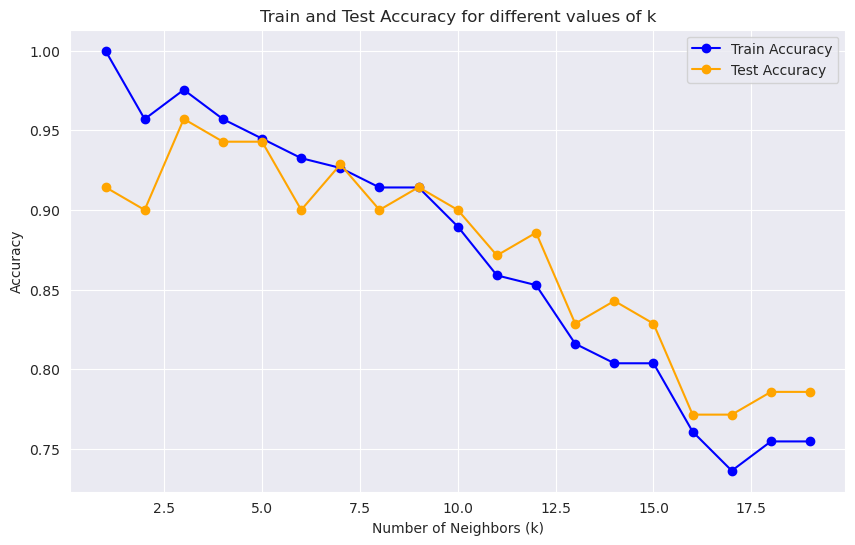

Pipeline(steps=[('scaler',
                 ColumnTransformer(transformers=[('text_preprocess',
                                                  OneHotEncoder(),
                                                  ['Star color', 'Star type']),
                                                 ('num_preprocess',
                                                  MinMaxScaler(),
                                                  Index(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)'],
      dtype='object'))])),
                ('knn', KNeighborsClassifier(n_neighbors=3))])

In [28]:
## 1) Testen Sie verschiedene Werte für k. 
## Erstellen Sie für jedes k eine eigene Pipeline mit dem selben Preprocessing wie 
##    'complete_pipeline' 
## aber einem K-NN Classifier mit passendem k.
## Trainieren Sie die Pipeline wie gehabt auf 
##   'stars_training' bzw. 'stars_training_class'
## Vergleichen Sie die Modelle anhand der Anzahl der richtigen Klassifizierungen 
## auf den Testdaten. 
## Speichern Sie dann 
##   - die Pipeline mit dem besten Modell in einer Variable 'knn_stars_pipeline' 
##   - die zugehörige Accuracy auf den Testdaten in einer Variablen 'best_knn_score'
## Nehmen Sie an, dass k nicht größer als 20 ist.
##
## 2) Visualisieren Sie außerdem die Accuracy sowohl auf den Trainings- als auch den Testdaten für 
## jedes k in *einer* entsprechenden, gemeinsamen Grafik. Verwenden Sie unterschiedliche Farben
## für die Accuracy auf den Test- bzw. Trainingsdaten.
## Orientieren Sie sich bei dem Diagramm an der Vorlesung, d.h. markieren Sie nicht nur die 
## tatsächlichen Werte, sondern verbinden Sie diese mit einer Linie.
##
## Diese Zelle soll nicht nur das beste Modell enthalten, sondern auch den Lösungsweg wie Sie 
## es gefunden haben, sowie den Code für die Visualisierung.

train_accuracies = []
test_accuracies = []
list_of_pipelines = []

for k in range(1, 20):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    complete_pipeline = Pipeline([
        ('scaler', complete_preprocessor),
        ('knn', knn_model)
    ])
    complete_pipeline.fit(stars_training, stars_training_class)
    train_accuracy = complete_pipeline.score(stars_training, stars_training_class)
    test_accuracy = complete_pipeline.score(stars_test, stars_test_class)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    list_of_pipelines.append(complete_pipeline)

best_test_accuracy = max(test_accuracies)
best_knn_score = test_accuracies.index(best_test_accuracy) + 1
knn_stars_pipeline = list_of_pipelines[test_accuracies.index(best_test_accuracy)]

print('===========')
print('Best model:')
print('k =', knn_stars_pipeline[1].n_neighbors)
print("Accuracy (Testdaten) =", best_knn_score)
print('===========')
print()

# Visualisierung der Accuracy
plt.figure(figsize=(10, 6))
k_values = range(1, 20)
plt.plot(k_values, train_accuracies, label='Train Accuracy', color='blue', marker='o')
plt.plot(k_values, test_accuracies, label='Test Accuracy', color='orange', marker='o')

# Achsenbeschriftung und Titel
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy for different values of k')
plt.legend()
plt.grid(True)
plt.show()

knn_stars_pipeline

In [29]:
# Pipeline:
assert type(knn_stars_pipeline) == Pipeline
assert len(knn_stars_pipeline.steps) == 2
assert knn_stars_pipeline.steps[0][1] == complete_preprocessor
assert type(knn_stars_pipeline.steps[1][1]) == KNeighborsClassifier

# Ergebnis:
assert knn_stars_pipeline.score(stars_test, stars_test_class) > complete_test_score             # Da ging noch was :-)
assert knn_stars_pipeline[1].n_neighbors != 5 and 2 < knn_stars_pipeline[1].n_neighbors < 7     # So viel sei verraten


Eine kleine Verbesserung durch die Wahl eines alterantiven Wertes für k scheint also noch möglich.

Damit schließen wir unsere Arbeit an der Klassifikation ab. Natürlich könnte man hier noch weitere Kombinationen/Ansätze ausprobieren - und es steht Ihnen natürlich offen, noch weiter zu arbeiten. Oder Sie können auch die von uns ignorierte Variante betrachten, und den Typ der Sterne zu bestimmen. Für den Umfang des Übungsblattes reicht das bis hierhin geleistete jedoch aus. 

# Clustering (Stromverbrauch eines Hauses)

Zum Einsatz von Clustering Methoden verwenden wir einen anderen Datensatz. Dieser Datensatz, Individual Household Electric Power Consumption [[Quelle](https://doi.org/10.24432/C58K54)], enthält Messungen zum Stromverbrauch eines Hauses (in Sceaux, Frankreich) zwischen 2006 und 2010. Die Messungen wurden im Abstand von jeweils einer Minute durchgeführt. Der originale Datensatz enthält dadurch 2049280 Einträge, wobei zu jedem Eintrag folgende Daten erhoben wurden:

1. Datum: Das aktuelle Datum
2. Zeit: Die aktuelle Uhrzeit
3. Global Active Power: Die auf die Minute gemittelte gesamte aktive elektrische Energie des Hauses (in Kilowatt)
4. Global Reactive Power: Die auf die Minute gemittelte gesamte reaktive elektrische Energie des Hauses (in Kilowatt)
5. Spannung: Auf die Minute gemittelte elektrische Spannung (in Volt)
6. Global Intensity: Die auf die Minute gemittelte Stromstärke für das gesamte Haus (in Ampere)
7. Sub Meter 1: Gemessener Energieverbrauch eines Sub-Zählers. Dieser misst den Verbrauch der Küche, welcher hauptsächlich aus dem Geschirrspüler, dem Backrohr und der Mikrowelle besteht (die Herdplatten sind gasbetrieben) (in Wattstunden an aktiver Energie)
8. Sub Meter 2: Gemessener Energieverbrauch eines Sub-Zählers. Dieser misst den Verbrauch der Waschküche, welche die Waschmaschine, einen Wäschetrockner, eine Gefriertruhe und das Licht beinhalten (in Wattstunden an aktiver Energie)
9. Sub Meter 3: Gemessener Energieverbrauch eines Sub-Zählers. Dieser misst den Verbrauch eines elektrischen Warmwasseraufbereiters und einer Klimaanlage.

Sowohl auf Grund der Größe des Datensatzes, als auch wegen teilweise fehlender Werte, werden wir nicht den originalen Datensatz für unser Clusteringproblem verwenden. Statt dessen betrachten wir aus diesem Datensatz aggregierte Werte: Wir interessieren uns für den Stromverbrauch im Tagesverlauf (also von Mitternacht bis Mitternacht). Dazu unterteilen wir den Tag in 5 Minuten Zeitfenster. Für jedes dieser Zeitfenster berechnen wir den durchschnittlichen Wert über alle Einträge im Datensatz, die in dieses Zeitfenster fallen. 

Gleichzeitig behalten wir auch nicht alle Merkmale, sondern betrachten nur die Merkmale

- __Global Active Power__
- __Global Intensity__
- __Global Reactive Power__
- __Sub Meter 1__
- __Sub Meter 2__
- __Sub Meter 3__

für jeden Timeslot. Wie beschrieben stellen die Werte für jedes Merkmal den Durchschnittswert aller Einträge dar, die in das entsprechende Zeitfenster fallen. Für das Zeitfenster von 00:00 bis 00:05 Uhr z.B. sind das über alle Tage des Datensatzes die Einträge in diesem Zeitfenster. Jeder Wert ist also der Durchschnitt von 7130 gemessenen Werten (356 Tage mal 5 Minuten mal fast 4 Jahre). 

Diese Werte sind im File ```HousoldPowerConsumption.csv``` zur Verfügung gestellt. 

Ziel dieser Aufgabe ist es nun mittels Clusteringverfahren Tageszeiten mit einem ähnlichen Energieverbrauchsverhalten zu finden. Wir verfolgen dabei kein konkretes Ziel (wie spezielle Stromtarife/Angebote zu entwickeln/anzubieten, den Verbrauch zu steuern), unsere Fragestellung ist eher, ob sich im Energieverbrauch möglicherweise gewisse Abläufe/Aktivitäten ablesen oder rückschließen lassen. 

Wir beginnen nun, indem wir den Datensatz laden. Da wir Muster/Gemeinsamkeiten im Stromverbrauch über den Tagesverlauf erkennen wollen, stellt das jeweilige Zeitfenster (Merkmal __timeslot__) keinen Wert da, den wir in unser Clustering aufnehmen wollen. Das Zeitfenster kann uns aber helfen, die gefunden Cluster zu interpretieren. Wir behalten dieses Merkmal daher als Teil des Datensatzes, verwenden es aber als Index für das DataFrame, und trennen es somit von den Werten über den gemessenen Stromverbrauch.

In [30]:
df_power_consumption = pd.read_csv('HousoldPowerConsumption.csv', sep=';', index_col=0)

df_power_consumption

,Global_active_power,Global_intensity,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3
Timeslot,,,,,,
0:0,0.750668,3.180533,0.118198,0.502665,0.686816,3.376578
0:5,0.743238,3.152174,0.118691,0.501122,0.709537,3.343619
0:10,0.718387,3.046564,0.117895,0.524544,0.637307,3.157504
0:15,0.696471,2.957195,0.117606,0.506311,0.617672,2.979383
0:20,0.674884,2.870194,0.116558,0.338058,0.616054,2.961970
...,...,...,...,...,...,...
23:35,0.844640,3.553296,0.117505,0.834642,0.732679,3.794670
23:40,0.819520,3.451697,0.117121,0.632118,0.698878,3.719355
23:45,0.807115,3.403338,0.118464,0.708135,0.668163,3.714306


Ein erstes Anzeichen, dass es gewisse Regelmäßigkeiten im Energieverbrauch des Hauses gibt, zeigt folgender Scatterplot, welcher auf der x-Achse die Zeit (00:00 Uhr ganz links, 23:59 Uhr rechts) in den 5-Minuten Zeitfenstern enthält, und auf der y-Achse die Gesamtmenge des verbrauchten Stroms. 

<img src="img/Tagesverlauf.png" alt="Gesamtemenge der verbrauchten Energie über den Tagsverlauf" width="1400"/>

Das heißt, obwohl über fast 4 Jahre (und somit u.a. verschiedene Jahreszeiten) gemittelt wurde, gibt es klare Unterschiede im Stromverbrauch über den Tagesverlauf. Wir wollen nun untersuchen, ob es neben der insgesamt verbrauchten Strommenge noch weitere Unterscheidungen gibt, die wir feststellen können.

## k-Means Clustering

Wir beginnen mit einem k-Means Clustering.
Da wir keine Vorgaben für k haben, müssen wir versuchen einen möglichst optimalen Wert für k zu bestimmen. Dafür untersuchen wir verschiedene Werte für k, und verwenden die beiden in der Vorlesung vorgestellten Methoden zur Evaluierung/Validierung von Clustern.

In [31]:
## Erstellen Sie k-means Clusterings der Einträge in 'df_power_consumption' für verschiedene Werte von 
## k und vergleichen Sie diese Modelle.
## Wenden Sie dazu die beiden(!) in der Vorlesung besprochenen Methoden an. 
## Erstellen Sie für jede der Methoden auch einen Plot, welcher das Ergebnis der Validierung in Abhängigkeit 
## von k zeigt.
## 
## WICHTIG!!
## Achten Sie darauf, dass Sie für das Clustering ausschließlich die Merkmale 
##   Global_active_power,
##   Global_intensity, 
##   Global_reactive_power,
##   Sub_metering_1, 
##   Sub_metering_2, 
##   Sub_metering_3
## verwenden, jedoch nicht den Index "timeslot" verwenden.
## 
## Speichern Sie das Modell mit dem besten Silhouetten-Koeffizienten in einer Variablen 'best_kmeans'.
## Speichern Sie den zugehörigen Score in einer Variablen 'max_kmeans_score'
##
## (Nehmen Sie an, dass k nicht größer als 20 ist)
##
## Diese Zelle soll nicht nur das beste Clustering enthalten, sondern auch den Lösungsweg wie Sie es gefunden haben,
## sowie den für die Visualisierung nötigen Code!

upper_bound = 20
features = ['Global_active_power','Global_intensity','Global_reactive_power'
            ,'Sub_metering_1','Sub_metering_2','Sub_metering_3']
list_of_models = []
list_of_scores = []

for k in range(2, upper_bound):
    data = df_power_consumption[features]
    model = KMeans(n_clusters=k, random_state=12044804, n_init='auto').fit(data)
    list_of_models.append(model)
    list_of_scores.append(silhouette_score(data, model.predict(data)))

max_kmeans_score = max(list_of_scores)
best_kmeans = list_of_models[list_of_scores.index(max_kmeans_score)]

print('======================')    
print('Best k (silhouette):', best_kmeans.n_clusters)
print('Value:', max_kmeans_score)
print('======================')

best_kmeans

Best k (silhouette): 5
Value: 0.6044756625905523


KMeans(n_clusters=5, random_state=12044804)

In [32]:
assert type(best_kmeans) == KMeans
k = best_kmeans.get_params()['n_clusters']
assert k > 3   # KMeans ist nicht deterministisch, daher prinzipiell auch k <= 3 möglich, 
               # aufgrund unserer Tests aber unwahrscheinlich
assert max_kmeans_score > 0.55   # Wiederum: kein deterministischer Wert und kann variieren, diese Eigenschaft 
               # in unseren Tesfällen immer gegeben


Wir möchten nun die gefunden Cluster zumindest oberflächlich betrachten, um zu sehen, welche ähnlichen Verbrauchsmuster das Clusteringverfahren gefunden hat. Dazu erstellen wir den bereits zuvor gezeigten Scatterplot, färben die Einträge aber entsprechend den gefundenen Clustern ein.

<Figure size 3000x1500 with 0 Axes>

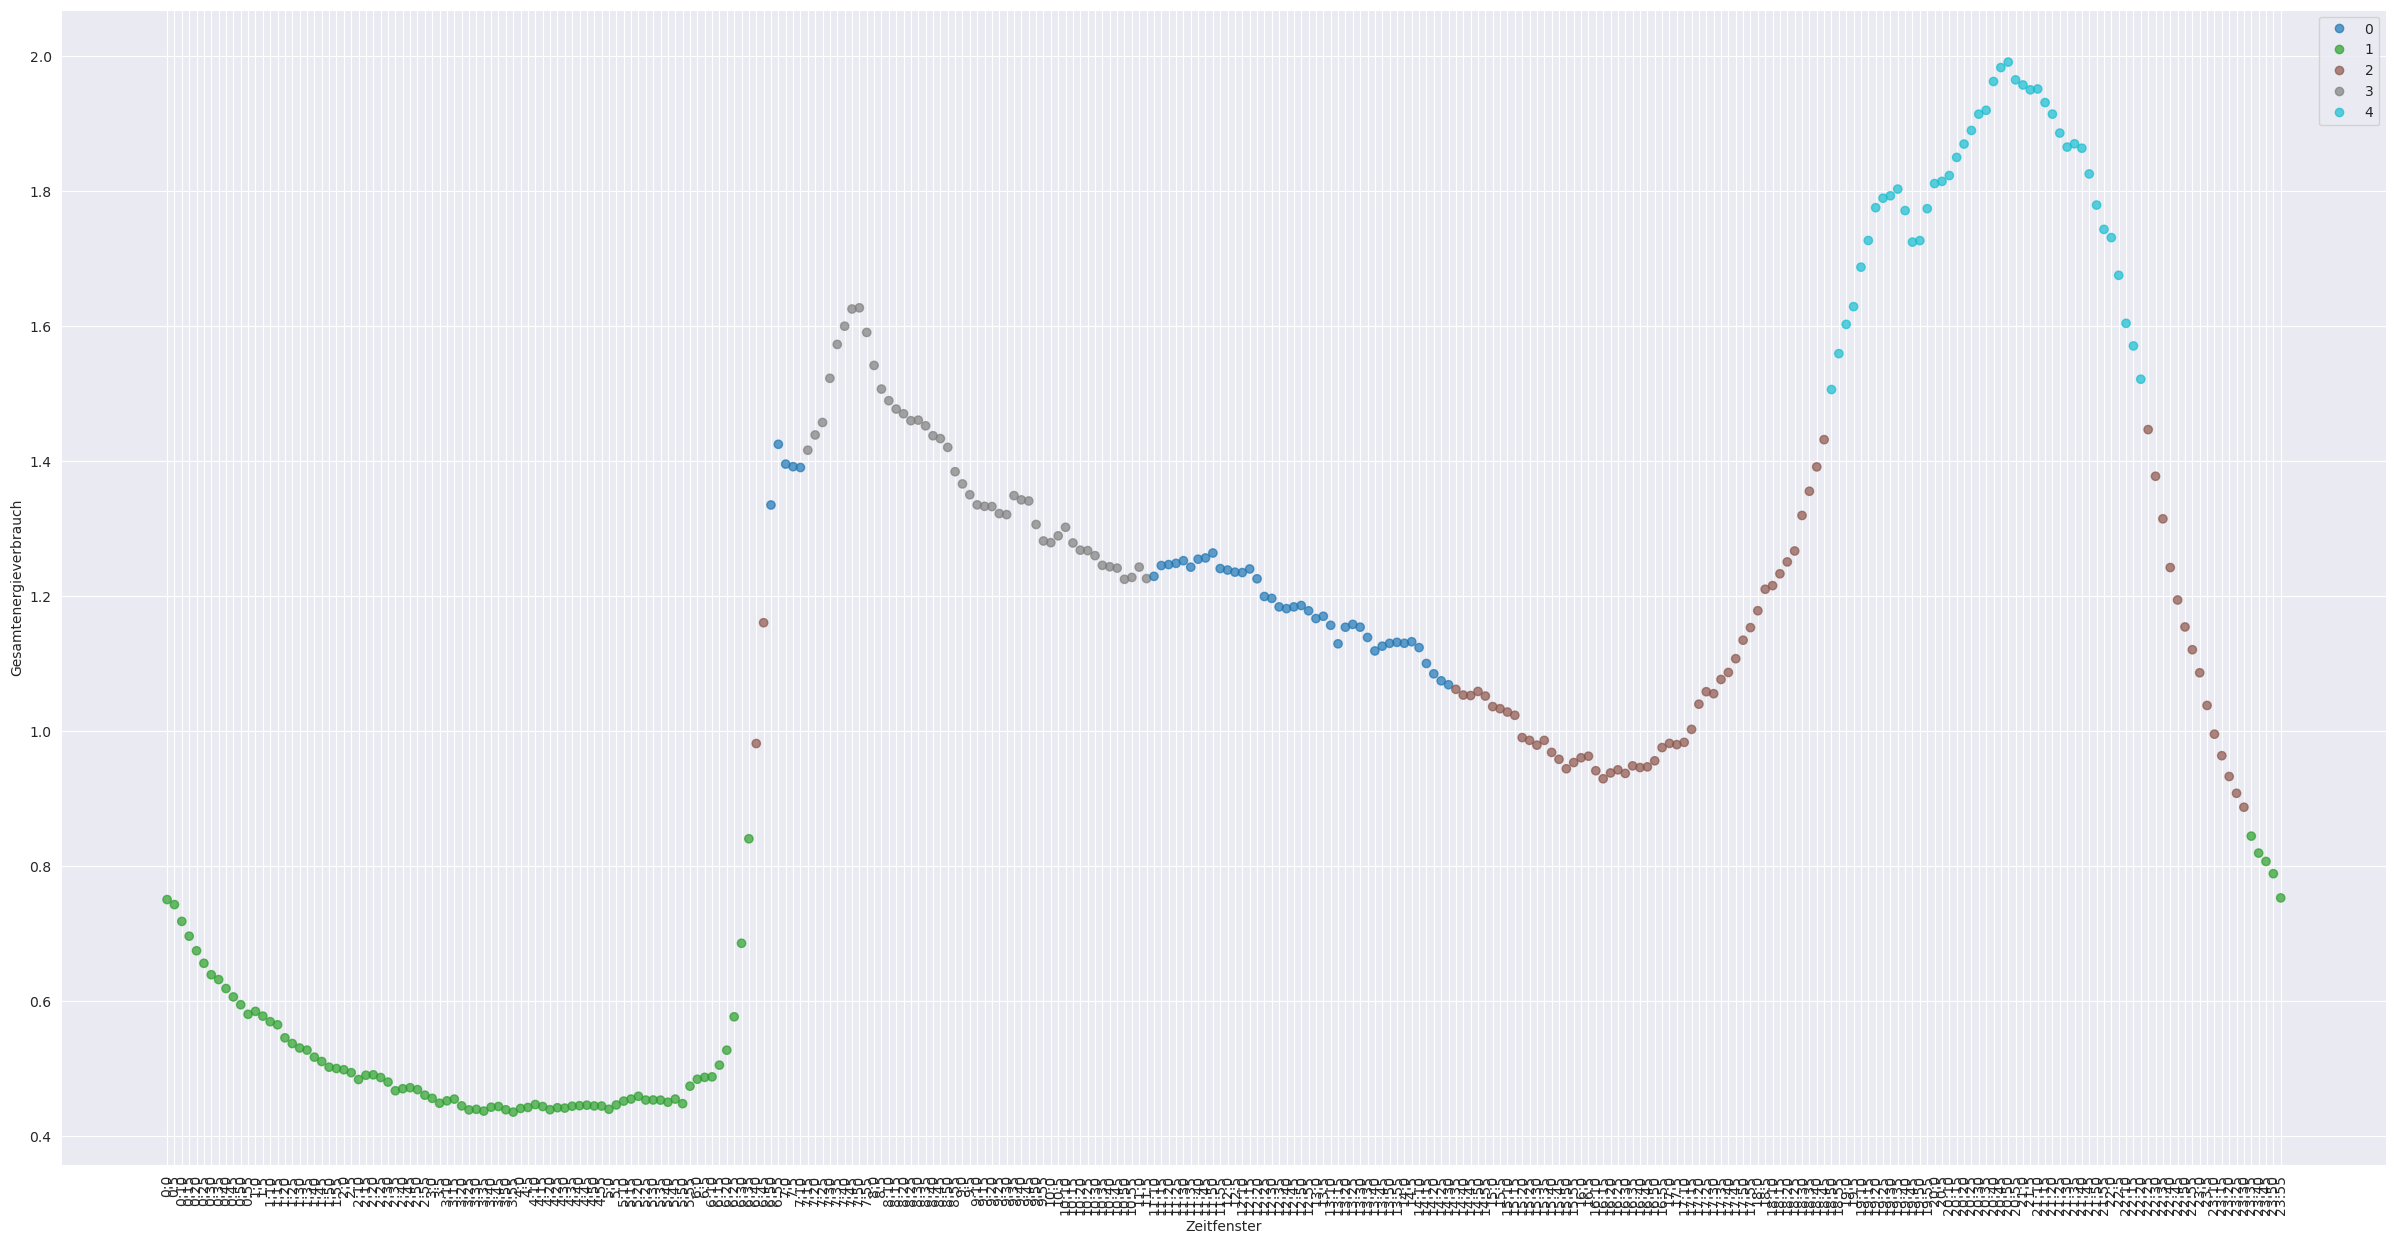

In [35]:
## Erstellen Sie den zuvor gezeigten Scatterplot, färben Sie jedoch die einzelnen 
## Einträge entsprechend dem gefundenen Clustering ein. D.h.
##
## Erstellen Sie einen Scatterplot welcher 
## - auf der x-Achse die Zeitfenster aufträgt (Die Index-Werte des DataFrames 'df_power_consumption'). 
## - auf der y-Achse die zugehörigen Werte von "Global_active_power" (laut 'df_power_consumption') aufträgt
## - verwenden Sie für jeden gefundenen Cluster eine unterschiedliche Farbe und färben Sie die zugehörigen 
##   Einträge damit ein
## 
## Speichern Sie eine Referenz auf den Plot in der Variablen 'scatter_1'

# Wir machen die Grafik etwas größer, um die Details zumindest erahnen zu können. 
# Falls sich das auf Ihrem Bildschirm nicht ausgeht, können Sie die Werte gerne 
# anpassen.
plt.figure(figsize=(30, 15))

df_power_consumption['Cluster'] = best_kmeans.predict(df_power_consumption[features])

plt.figure(figsize=(30, 15))
scatter_1 = plt.scatter(
    df_power_consumption.index,  
    df_power_consumption['Global_active_power'],  
    c=df_power_consumption['Cluster'],  
    cmap='tab10',  
    alpha=0.7  
)

# Wir fügen eine Legende hinzu und rotieren die Labels der x-Achse um 90 Grad, um weniger 
# Überlappungen zu erhalten.
handles, labels = scatter_1.legend_elements()
plt.xlabel('Zeitfenster')
plt.ylabel('Gesamtenergieverbrauch')
plt.legend(handles, labels)
plt.xticks(rotation=90)

scatter_1

In [36]:
# Plot:
assert scatter_1 != None


Das Clustering zeigt, dass sich im Stromverbrauch offensichtlich zeitlich zusammehängende, kohärente Verbrauchsmuster finden. Versuchen Sie ein bisschen zu spekulieren, woraus sich diese Muster ergeben könnten. Welche Gründe könnte es dafür geben? Und lassen sich daraus evtl. sogar Verhaltensweisen ablesen? (Keine Eingabe/Abgabe erforderlich, versuchen Sie nur die Ergebnisse ein wenig zu interpretieren.)

Wenn Sie ein bisschen über mögliche Gründe spekuliert haben, betrachten Sie folgende Visualisierung der Cluster - diesmal entlang von drei Achsen, wobei jede Ache den gemessenen Energieverbrauch eines der drei Sub-Meter anzeigt. Deckt sich das Gezeigte mit Ihren Überlegungen? Hatten Sie eine andere Idee? (Keine Eingabe/Abgabe erforderlich.)

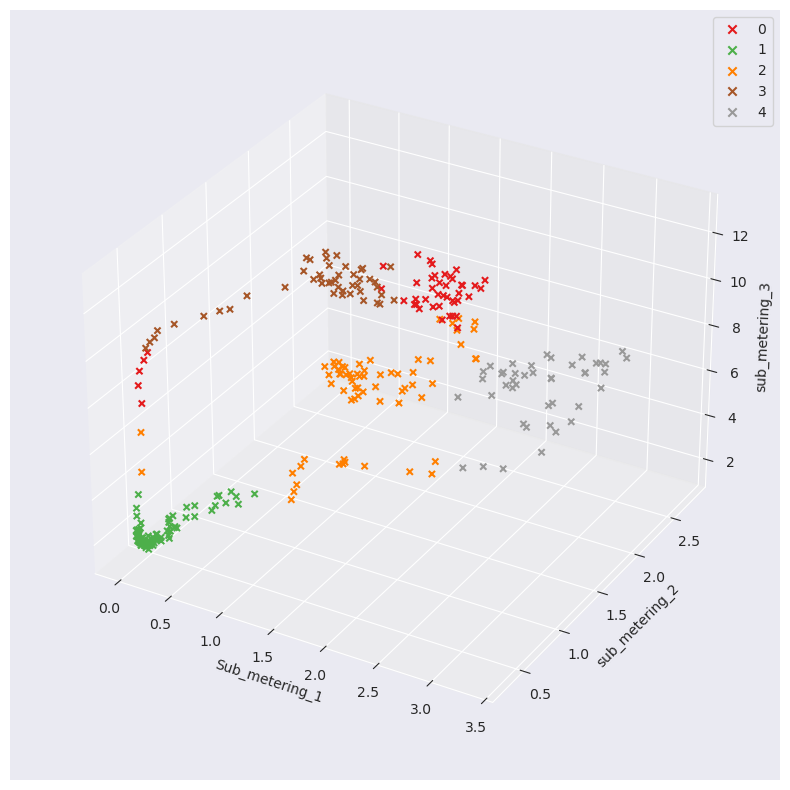

In [37]:
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(projection='3d')
plot_3d = ax.scatter(df_power_consumption["Sub_metering_1"], df_power_consumption["Sub_metering_2"], df_power_consumption["Sub_metering_3"], c=best_kmeans.labels_, marker='x', alpha=1, cmap='Set1')
ax.set_xlabel('Sub_metering_1')
ax.set_ylabel('sub_metering_2')
ax.set_zlabel('sub_metering_3')
ax.set_box_aspect(None, zoom=0.92)
handles, labels = plot_3d.legend_elements()
plt.legend(handles, labels)


## Agglomeratives Clustering

Das Ergebnis des k-Means Clusterings kann sich von Durchlauf zu Durchlauf ändern - hängt es doch von den zufällig gewählten Startwerten ab. Wenn Ihnen bislang noch keine Änderungen an den Ergebnissen des k-Means Clusterings in verschiedenen Durchläufen aufgefallen sind, führen Sie die Zelle mit dem k-Means Clustering und der Visualisierung ein paar mal (vielleicht auch mit zeitlichem Abstand) aus, und beachten Sie die Graphen. Im Allgemeinen ergeben sich hier auch "mit dem freien Auge" erkennbare Unterschiede.

Bei unseren (= während des Erstellens der Aufgaben) Versuchen war das k welches den besten Wert geliefert hat recht stabil. Trotzdem kam es hin und wieder zu teilweise unterschiedlichen Ergebnissen. In diesem Fall sind die Schwankungen nicht so groß, und das Ergebnis im Bezug auf das "beste" k scheint recht stabil. Trotzdem betrachten wir noch ein zweites Clustering-Verfahren, welches deterministische Ergebnisse liefert - nämlich Hierarchisches Clustering. 

Dabei verwenden wir die euclidean Metrik, und werden zwei verschiedene Linkage-Ansätze ausprobieren. 
Wir beginnen mit jener Methode, welche ein möglichst ähnliches Clustering zum k-Means Verfahren erzeugen sollte, und verwenden "ward linkage".


Best k (silhouette): 4
Value: 0.5801954996206303


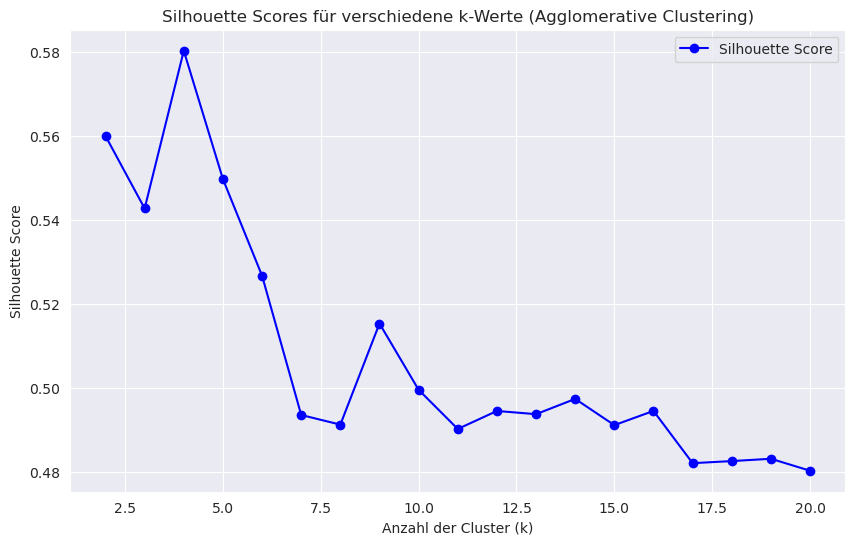

AgglomerativeClustering(n_clusters=4)

In [40]:
## Erstellen Sie Agglomerative Clusterings mit k Clustern und ward linkage für 
## den Datensatz in 'df_power_consumption'.
## Testen Sie verschiedene Werte für k und vergleichen Sie die erstellten 
## Modelle mit der in der Vorlesung dafür vorgestellten Methode.
## 
## - Speichern Sie das beste Modell in einer Variable 'best_agglo_ward'
## - Speichern Sie den besten erreichten Score in der Variablen 'max_agglo_ward_score'
## - Visualisieren Sie den entsprechenden Score für die getesteten Werte von k in einer Grafik
##
## (Nehmen Sie an, dass k nicht größer als 20 ist)
##
## WICHTIG!!
## Achten Sie wiederum darauf, dass das Clustering nicht auf den Werten für die Zeitfenster 
## (00:00 Uhr, 20:15 Uhr, etc.) basiert, sondern ausschließlich auf den gemessenen 
## Energiewerten.
##
## Diese Zelle soll nicht nur das beste Clustering enthalten sondern auch den 
## Lösungsweg wie Sie es gefunden haben, sowie den Code für die Visualisierung.
## 
## Hinweis: Die Berechnung der Clusterings kann einige Zeit in Anspruch nehmen

upper_bound = 20

data = df_power_consumption[features]

list_of_models = []
list_of_scores = []

for k in range(2, upper_bound + 1):
    model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    cluster_labels = model.fit_predict(data)
    score = silhouette_score(data, cluster_labels)
    list_of_models.append(model)
    list_of_scores.append(score)

max_agglo_ward_score = max(list_of_scores)
best_agglo_ward = list_of_models[list_of_scores.index(max_agglo_ward_score)]

print('\n======================')
print('Best k (silhouette):', best_agglo_ward.n_clusters)
print('Value:', max_agglo_ward_score)
print('======================')

plt.figure(figsize=(10, 6))
plt.plot(range(2, upper_bound + 1), list_of_scores, marker='o', color='b', label='Silhouette Score')
plt.xlabel('Anzahl der Cluster (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores für verschiedene k-Werte (Agglomerative Clustering)')
plt.grid(True)
plt.legend()
plt.show()

best_agglo_ward

In [41]:
# Ein paar Testfälle
k = best_agglo_ward.n_clusters
assert type(best_agglo_ward) == AgglomerativeClustering            # korrektes Clustering
assert best_agglo_ward.linkage == 'ward'                           # korrektes linkage
assert 3 < k < 10     # irgendwo da sollte die Lösung liegen
assert best_agglo_ward.get_params()['metric'] == 'euclidean'  # Standardwert, lassen wir unverändert



Wir probieren auch eine alternative Methode für das Linkage aus, und verwenden _complete_.


Best k (silhouette): 5
Value: 0.56778459789409


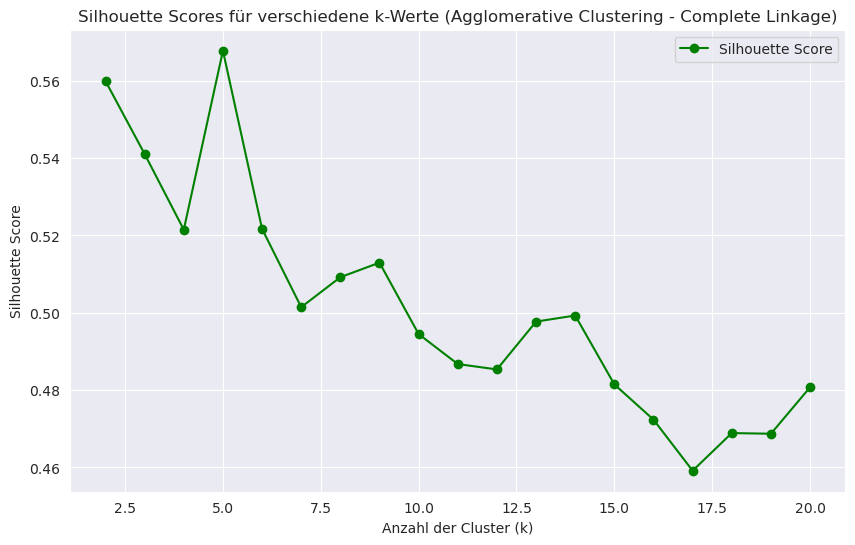

AgglomerativeClustering(linkage='complete', n_clusters=5)

In [42]:
## Erstellen Sie Agglomerative Clusterings mit k Clustern und complete linkage für 
## den Datensatz in 'df_power_consumption'.
## Testen Sie verschiedene Werte für k und vergleichen Sie die erstellten 
## Modelle mit der in der Vorlesung dafür vorgestellten Methode.
## 
## - Speichern Sie das beste Modell in der Variable 'best_agglo_complete'
## - Speichern Sie den besten erreichten Score in der Variable 'max_agglo_complete_score'
## - Visualisieren Sie den entsprechenden Score für die getesteten Werte von k in einer Grafik
##
## (Nehmen Sie an, dass k nicht größer als 20 ist)
##
## WICHTIG!!
## Achten Sie wiederum darauf, dass das Clustering nicht auf den Werten für die Zeitfenster 
## (00:00 Uhr, 20:15 Uhr, etc.) basiert, sondern ausschließlich auf den gemessenen 
## Energiewerten.
##
## Diese Zelle soll nicht nur das beste Clustering enthalten sondern auch den 
## Lösungsweg wie Sie es gefunden haben, sowie den Code für die Visualisierung.
## 
## Hinweis: Die Berechnung der Clusterings kann einige Zeit in Anspruch nehmen

upper_bound = 20

data = df_power_consumption[features]

list_of_models = []
list_of_scores = []

for k in range(2, upper_bound + 1):
    model = AgglomerativeClustering(n_clusters=k, linkage='complete')
    cluster_labels = model.fit_predict(data)
    score = silhouette_score(data, cluster_labels)
    list_of_models.append(model)
    list_of_scores.append(score)

max_agglo_complete_score = max(list_of_scores)
best_agglo_complete = list_of_models[list_of_scores.index(max_agglo_complete_score)]

print('\n======================')
print('Best k (silhouette):', best_agglo_complete.n_clusters)
print('Value:', max_agglo_complete_score)
print('======================')

plt.figure(figsize=(10, 6))
plt.plot(range(2, upper_bound + 1), list_of_scores, marker='o', color='g', label='Silhouette Score')
plt.xlabel('Anzahl der Cluster (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores für verschiedene k-Werte (Agglomerative Clustering - Complete Linkage)')
plt.grid(True)
plt.legend()
plt.show()

best_agglo_complete

In [43]:
# Ein paar Testfälle
k = best_agglo_complete.n_clusters
assert type(best_agglo_complete) == AgglomerativeClustering          # korrektes Clustering
assert best_agglo_complete.linkage == 'complete'                      # korrektes linkage
assert 3 < k < 10     # irgendwo da sollte die Lösung liegen
assert best_agglo_complete.metric == 'euclidean'  # Standardwert, lassen wir unverändert



Zum Abschluss möchten wir auch diese Clusterings zumindest ein klein wenig verstehen, d.h. wir erstellen den selben Scatterplot wie zuvor, je einen für jedes der beiden Agglomerativen Clusterings.

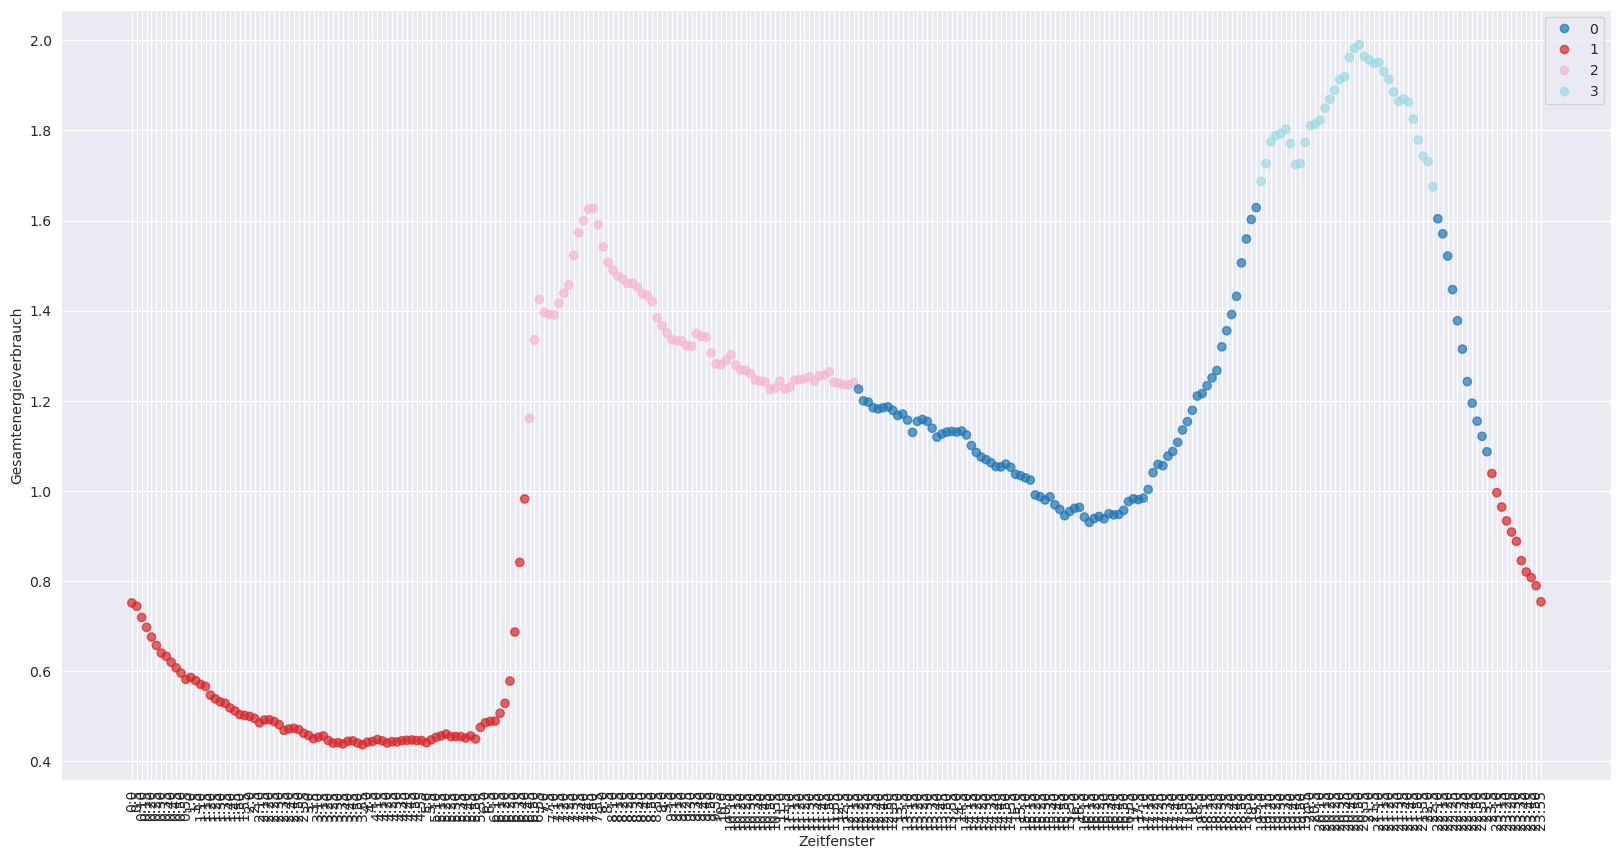

In [45]:
## Erstellen Sie den selben Scatterplot wie zuvor für das Ergebnis des k-Means Clusterings
## (Grafik gespeichert in scatter_1), nur färben Sie die Datenpunkte entsprechend dem 
## Clustering in 'best_agglo_ward' ein.
##
## Speichern Sie eine Referenz auf den Plot in der Variablen scatter_2 ab.

plt.figure(figsize=(20, 10))

df_power_consumption['Ward_Cluster'] = best_agglo_ward.fit_predict(df_power_consumption[features])

scatter_2 = plt.scatter(
    df_power_consumption.index,  
    df_power_consumption['Global_active_power'], 
    c=df_power_consumption['Ward_Cluster'],  
    cmap='tab20',  
    alpha=0.7  
)


# Wir fügen eine Legende hinzu und rotieren die Labels der x-Achse um 90 Grad, um weniger 
# Überlappungen zu erhalten.
handles, labels = scatter_2.legend_elements()
plt.xlabel('Zeitfenster')
plt.ylabel('Gesamtenergieverbrauch')
plt.legend(handles, labels)
plt.xticks(rotation=90)

scatter_2

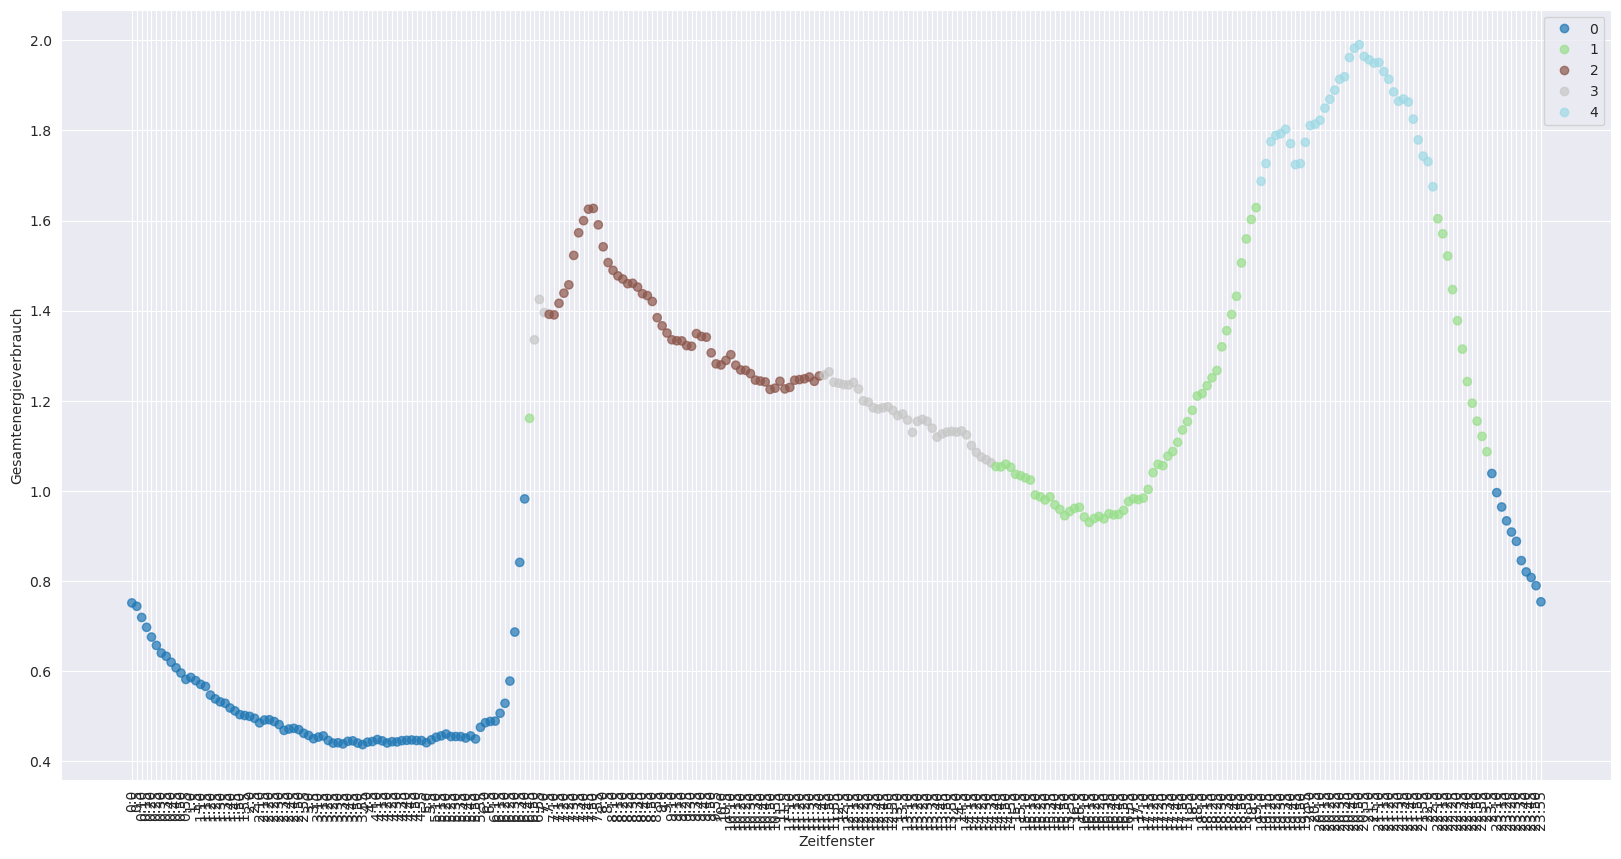

In [46]:
## Erstellen Sie den selben Scatterplot wie zuvor für das Ergebnis des k-Means Clusterings
## (Grafik gespeichert in scatter_1), nur färben Sie die Datenpunkte entsprechend dem 
## Clustering in 'best_agglo_complete' ein.
##
## Speichern Sie eine Referenz auf den Plot in der Variablen scatter_3 ab.

plt.figure(figsize=(20, 10))

df_power_consumption['Complete_Cluster'] = best_agglo_complete.fit_predict(df_power_consumption[features])

scatter_3 = plt.scatter(
    df_power_consumption.index,  
    df_power_consumption['Global_active_power'],  
    c=df_power_consumption['Complete_Cluster'],  
    cmap='tab20',  
    alpha=0.7 
)

# Wir fügen eine Legende hinzu und rotieren die Labels der x-Achse um 90 Grad, um weniger 
# Überlappungen zu erhalten.
handles, labels = scatter_3.legend_elements()
plt.xlabel('Zeitfenster')
plt.ylabel('Gesamtenergieverbrauch')
plt.legend(handles, labels)
plt.xticks(rotation=90)

scatter_3

In [47]:
# Plot:
assert scatter_2 != None
assert scatter_3 != None


# Ende
Damit haben Sie auch das 4. Übungsblatt fertig durchgearbeitet. Gratulation (nur mehr eines übrig :-) ) 

Bitte melden Sie sich bei Fragen, Problemen oder Unklarheiten rechtzeitig.